In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import time
import calendar
import math
from datetime import datetime as dt
from scipy.stats import norm
N = norm.cdf
r = 0.025
def bsm_price(option_type, S, k, r, T, sigma):
    sigma = float(sigma)
    d1 = (np.log(S/k) + (r + sigma**2 * 0.5) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'Call':
        price = np.exp(-r*T) * (S * np.exp(r*T) * norm.cdf(d1) - k*norm.cdf(d2))
        return price
    elif option_type == 'Put':
        price = np.exp(-r*T) * (k * norm.cdf(-d2) - S * np.exp(r*T) *  norm.cdf(-d1))
        return price
        
def impliedvol_Call(option_price, S, k, T):
    precision = 0.00001
    u = 500.0
    l = 0.0001
    iteration = 0
    option_type = 'Call'
    r = 0.025 
    while 1:
        iteration +=1
        m = (u + l)/2.0
        price = bsm_price(option_type,S, k, r, T, m)
        l_price = bsm_price(option_type,S, k, r, T, l)
        if (l_price - option_price) * (price - option_price) > 0:
            l = m
        else:
            u = m
        if abs(price - option_price) < precision:
            break 
        if iteration > 50: 
            break
    return m
                
def impliedvol_Put(option_price, S, k, T):
    precision = 0.00001
    u = 500.0
    l = 0.0001
    iteration = 0
    r = 0.025
    option_type = 'Put'
    while 1:
        iteration +=1
        m = (u + l)/2.0
        price = bsm_price(option_type,S, k, r, T, m)
        u_price = bsm_price(option_type,S, k, r, T, u)
        if (u_price - option_price) * (price - option_price) > 0:
            u = m
        else:
            l = m
        if abs(price - option_price) < precision:
            break 
        if iteration > 50: 
            break
    return m
            
#tesla = yf.Ticker('MSFT')
#print(tesla.info['enterpriseValue'])
#print(f"Market Cap : {tesla.info['marketCap']}\n")

C:\Users\satyadev\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
import yfinance as yf
import mplfinance as mpf
import datetime

def options_chain(option_type,symbol):
    stock_data = yf.download(symbol,start = datetime.datetime(2020,1,1),end = datetime.datetime.today())
    tk = yf.Ticker(symbol)
    exps = tk.options
    options = pd.DataFrame()
    for exp in exps:
        opt = tk.option_chain(exp)
        if(option_type == 'Call'):
            opt = pd.DataFrame().append(opt.calls)
        else:
            opt = pd.DataFrame().append(opt.puts)
        opt['expirationDate'] = exp
        options = options.append(opt, ignore_index=True)

    options['expirationDate'] = pd.to_datetime(options['expirationDate']) + datetime.timedelta(days = 1)
    options['expirationDate_str'] = options['expirationDate'].astype(str).str[0:10]
    options['lastTradeDate_str'] = options['lastTradeDate'].astype(str).str[0:10]
    options['dtexp'] = (options['expirationDate'] + datetime.timedelta(days = 1) - datetime.datetime.today()).dt.days / 365
    
    #options['CALL'] = options['contractSymbol'].str[4:].apply(lambda x: "C" in x)
    options[['bid', 'ask', 'strike']] = options[['bid', 'ask', 'strike']].apply(pd.to_numeric)
    options['price'] = (options['bid'] + options['ask']) / 2
    #options['Stock_Today'] = (stock_data.loc[str(datetime.datetime.today() - datetime.timedelta(days = 2))[:10]]['High'] + stock_data.loc[str(datetime.datetime.today() - datetime.timedelta(days = 2))[:10]]['Low'])/2
    options['Stockat_TradeDate'] = options['lastTradeDate_str'].apply(lambda x: (stock_data.loc[x]['High'] + stock_data.loc[x]['Low'])/2 )
    #if(option_type == 'Call'):
    #    options['impliedVol'] = options.apply(lambda x: impliedvol_Call(x['lastPrice'], x['Stockat_TradeDate'],x['strike'],x['dtexp']))
    #else:
    #    options['impliedVol'] = options.apply(lambda x: impliedvol_Put(x['lastPrice'], x['Stockat_TradeDate'],x['strike'],x['dtexp']))

    options = options.drop(columns = ['contractSize', 'currency', 'change', 'percentChange'])

    return options

In [21]:
symbol = 'AAPL'
AAPL_calls = options_chain('Call',symbol)
AAPL_puts = options_chain('Put',symbol)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [22]:
print(AAPL_calls)
print(AAPL_puts)

          contractSymbol             lastTradeDate  strike  lastPrice    bid  \
0    AAPL220429C00100000 2022-04-22 19:33:36+00:00   100.0      64.05  60.10   
1    AAPL220429C00105000 2022-04-04 14:01:52+00:00   105.0      72.85  55.60   
2    AAPL220429C00110000 2022-04-07 19:48:28+00:00   110.0      63.06  50.50   
3    AAPL220429C00115000 2022-04-14 14:21:52+00:00   115.0      53.60  45.55   
4    AAPL220429C00120000 2022-04-22 16:14:14+00:00   120.0      44.45  40.30   
..                   ...                       ...     ...        ...    ...   
821  AAPL240621C00280000 2022-04-20 17:53:00+00:00   280.0       5.63   3.55   
822  AAPL240621C00290000 2022-04-20 15:05:08+00:00   290.0       4.90   2.83   
823  AAPL240621C00300000 2022-04-22 17:04:30+00:00   300.0       4.25   3.65   
824  AAPL240621C00310000 2022-04-22 19:32:08+00:00   310.0       3.85   3.00   
825  AAPL240621C00320000 2022-04-22 19:26:06+00:00   320.0       3.20   3.10   

       ask  volume  openInterest  impli

In [24]:
calls = AAPL_calls.drop(['lastTradeDate'],axis = 1)#,'expirationDate','expirationDate_str','lastTradeDate_str','dtexp'], axis = 1)

In [28]:
puts = AAPL_puts.drop(['lastTradeDate'],axis = 1)#,'expirationDate','expirationDate_str','lastTradeDate_str','dtexp'], axis = 1)

In [26]:
file_name = 'AAPL_Calldata.xlsx'
calls.to_excel(file_name)

In [30]:
file_name = 'AAPL_Putdata.xlsx'
puts.to_excel(file_name)

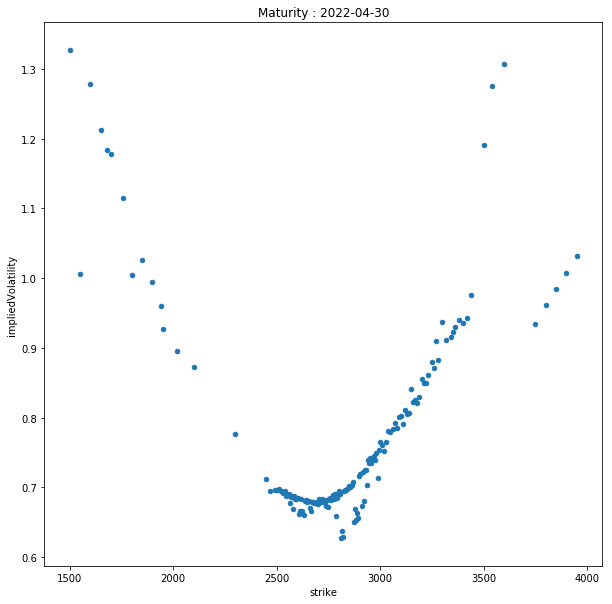

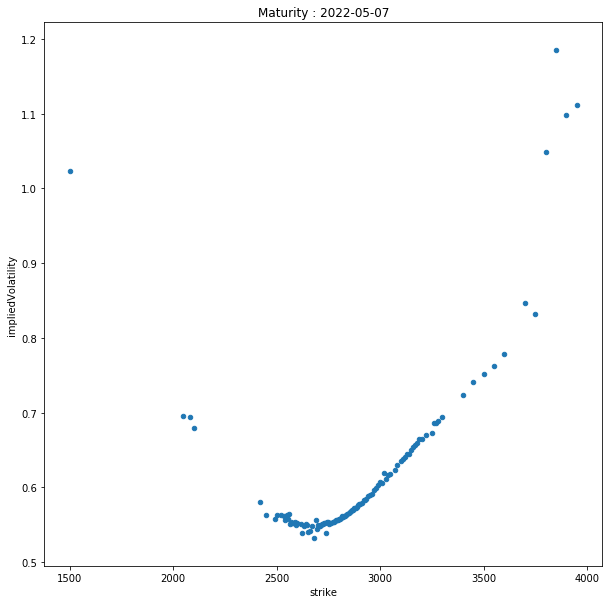

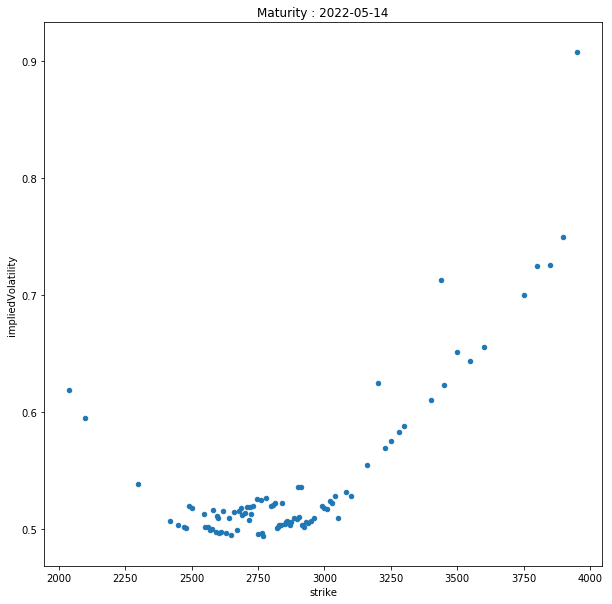

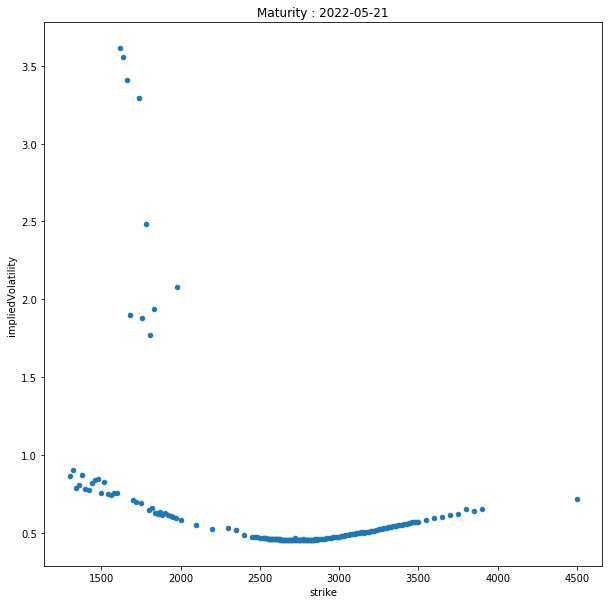

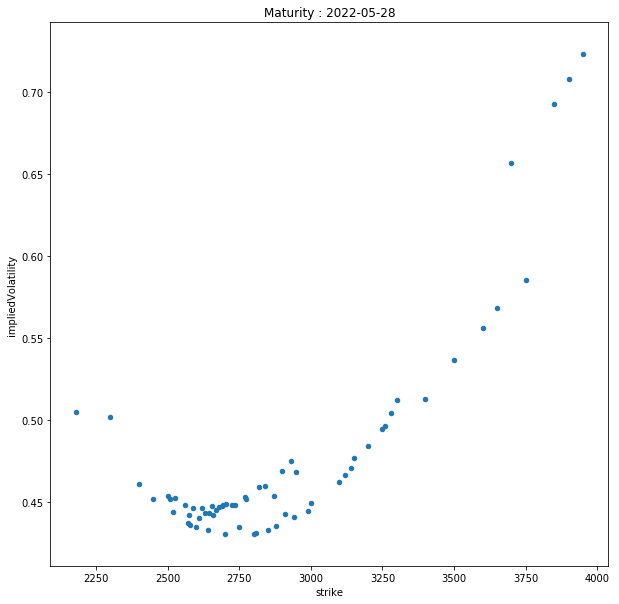

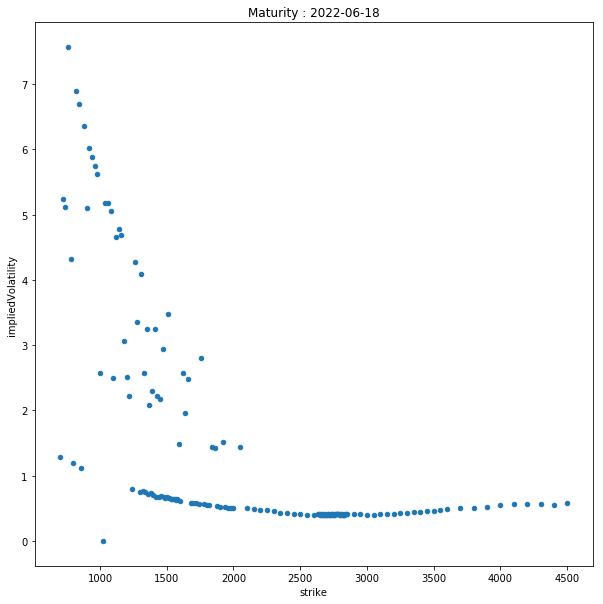

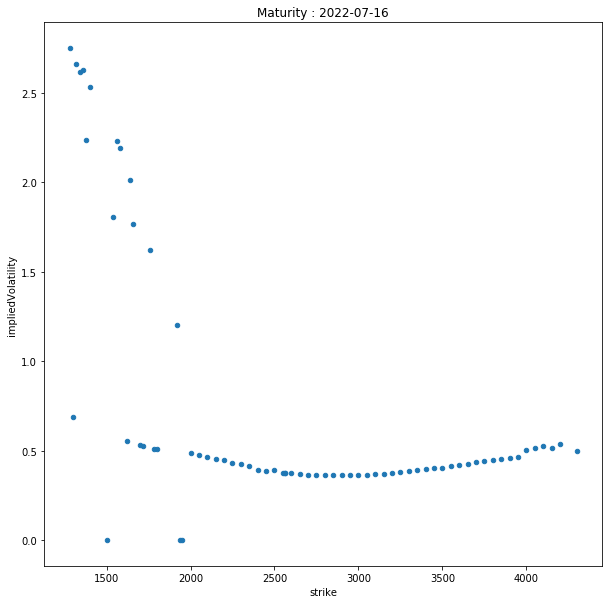

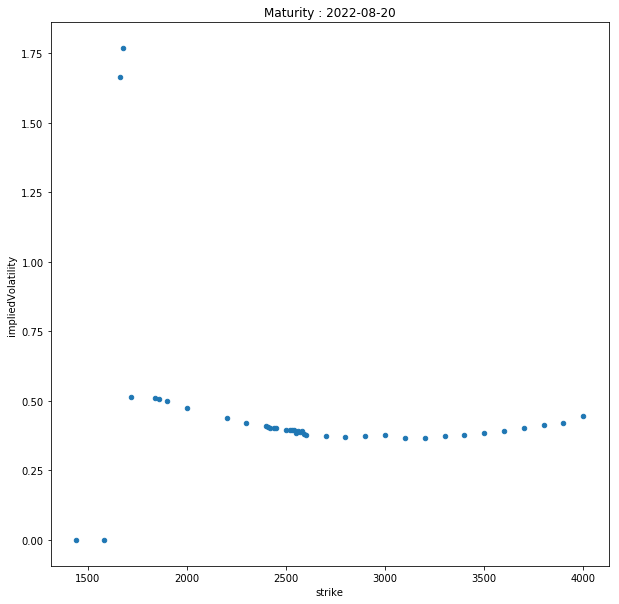

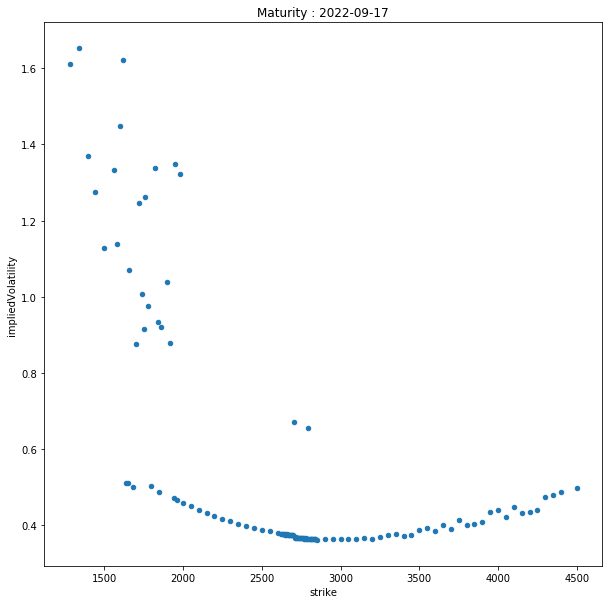

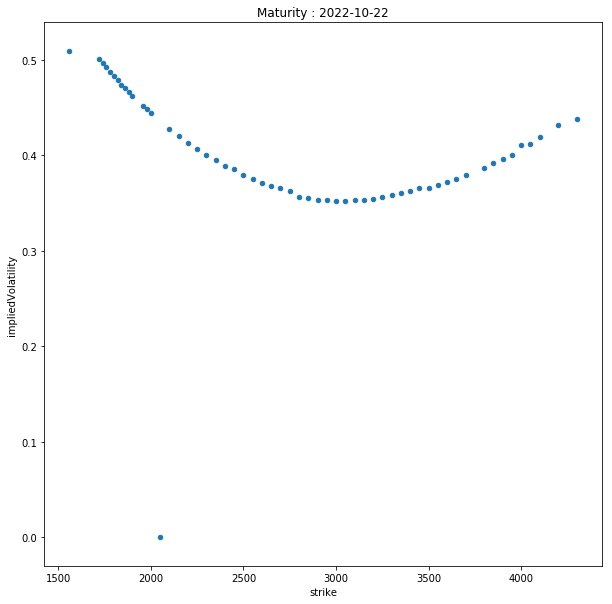

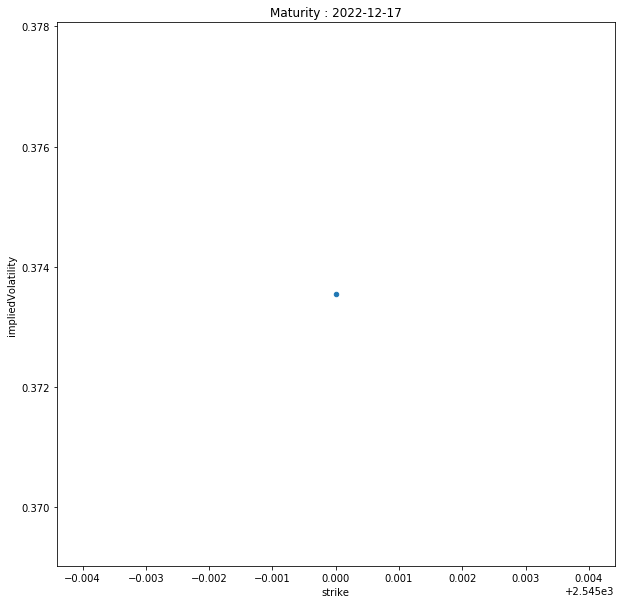

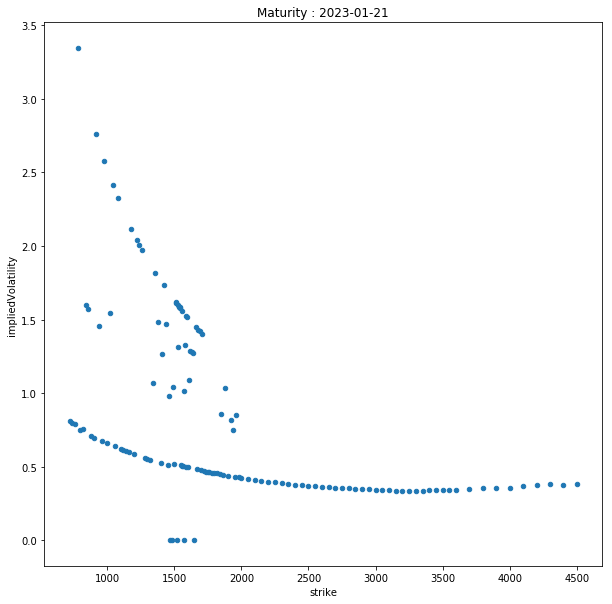

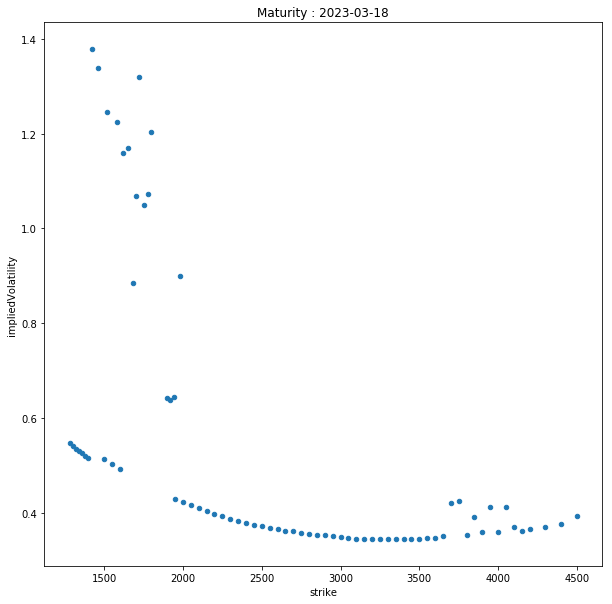

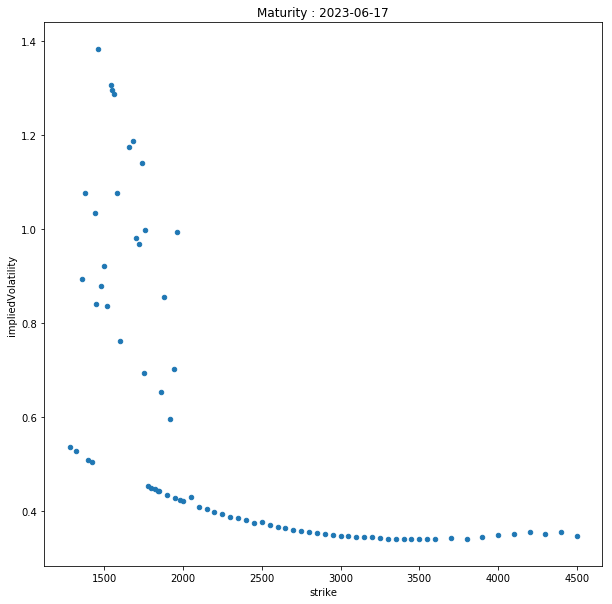

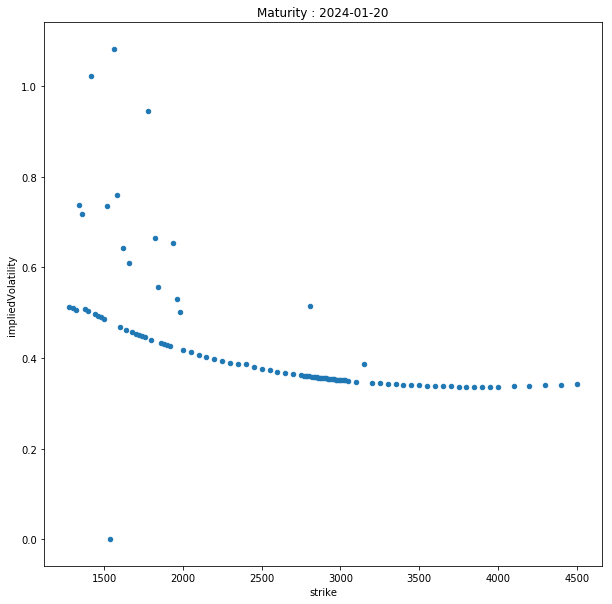

In [4]:
for date in calls.expirationDate.unique():
    calls1 = calls[(calls['expirationDate'] == date)]
    calls1.plot(x = 'strike', y = 'impliedVolatility', kind = "scatter",figsize =  (10,10))
    plt.title("Maturity : " + str(date)[:10])

plt.show()

In [5]:
calls.expirationDate.unique()

array(['2022-04-30T00:00:00.000000000', '2022-05-07T00:00:00.000000000',
       '2022-05-14T00:00:00.000000000', '2022-05-21T00:00:00.000000000',
       '2022-05-28T00:00:00.000000000', '2022-06-18T00:00:00.000000000',
       '2022-07-16T00:00:00.000000000', '2022-08-20T00:00:00.000000000',
       '2022-09-17T00:00:00.000000000', '2022-10-22T00:00:00.000000000',
       '2022-12-17T00:00:00.000000000', '2023-01-21T00:00:00.000000000',
       '2023-03-18T00:00:00.000000000', '2023-06-17T00:00:00.000000000',
       '2024-01-20T00:00:00.000000000'], dtype='datetime64[ns]')

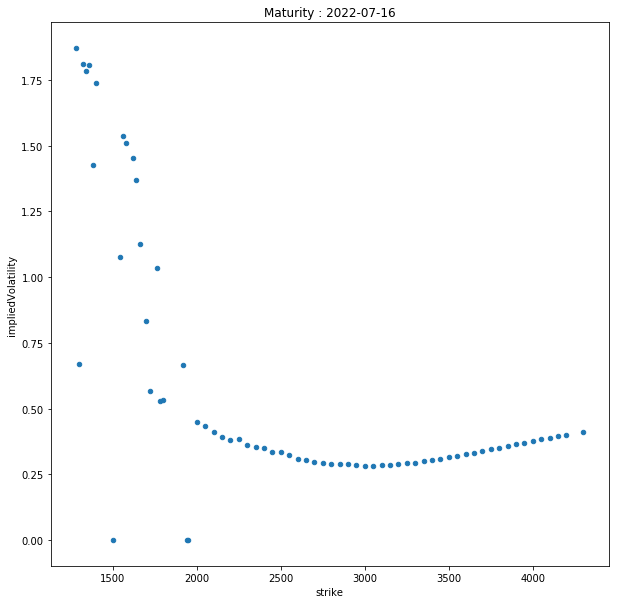

In [7]:
date = '2022-07-16T00:00:00.000000000'
calls1 = calls[(calls['expirationDate'] == date)]
calls1.plot(x = 'strike', y = 'impliedVolatility', kind = "scatter",figsize =  (10,10))
plt.title("Maturity : " + str(date)[:10])
plt.show()

In [7]:
calls = options_chain('Call','GOOG')

[*********************100%***********************]  1 of 1 completed


In [9]:
st_price = list(calls.strike.unique())
st_price.sort()
st_price

[700.0,
 720.0,
 740.0,
 760.0,
 780.0,
 800.0,
 820.0,
 840.0,
 860.0,
 880.0,
 900.0,
 920.0,
 940.0,
 960.0,
 980.0,
 1000.0,
 1020.0,
 1040.0,
 1060.0,
 1080.0,
 1100.0,
 1120.0,
 1140.0,
 1160.0,
 1180.0,
 1200.0,
 1220.0,
 1240.0,
 1260.0,
 1280.0,
 1300.0,
 1310.0,
 1320.0,
 1325.0,
 1330.0,
 1340.0,
 1350.0,
 1360.0,
 1370.0,
 1375.0,
 1380.0,
 1390.0,
 1400.0,
 1410.0,
 1420.0,
 1425.0,
 1430.0,
 1440.0,
 1450.0,
 1460.0,
 1470.0,
 1480.0,
 1490.0,
 1500.0,
 1510.0,
 1515.0,
 1520.0,
 1525.0,
 1530.0,
 1535.0,
 1540.0,
 1545.0,
 1550.0,
 1555.0,
 1560.0,
 1565.0,
 1570.0,
 1575.0,
 1580.0,
 1585.0,
 1590.0,
 1595.0,
 1600.0,
 1610.0,
 1620.0,
 1630.0,
 1640.0,
 1650.0,
 1660.0,
 1670.0,
 1680.0,
 1690.0,
 1700.0,
 1710.0,
 1720.0,
 1740.0,
 1750.0,
 1760.0,
 1770.0,
 1780.0,
 1800.0,
 1810.0,
 1820.0,
 1830.0,
 1840.0,
 1850.0,
 1860.0,
 1870.0,
 1880.0,
 1890.0,
 1900.0,
 1910.0,
 1920.0,
 1930.0,
 1940.0,
 1950.0,
 1960.0,
 1970.0,
 1980.0,
 2000.0,
 2020.0,
 2040.0,
 2050.0

In [10]:
def impVol_df(opt,symbol):
    calls = options_chain(opt,symbol)
    ex_date = list(calls.dtexp.unique())
    ex_date = [str(a)[:10] for a in ex_date]
    ex_date.sort()
    st_price = list(calls.strike.unique())
    st_price.sort()
    st_key = dict()
    for i in range(len(st_price)):
        st_key[st_price[i]] = i
    ex_key = dict()
    for i in range(len(ex_date)):
        ex_key[ex_date[i]] = i
    vol_df = pd.DataFrame(columns=['st_price'] + ex_date)
    vol_df['st_price'] = st_price
    for i in range(len(calls)):
        x = st_key[calls.loc[i,'strike']]
        y = ex_key[str(calls.loc[i,'dtexp'])[:10]]
        vol_df.iloc[x,y] = calls.loc[i,'impliedVolatility']
    vol_df = vol_df.set_index('st_price')
    return vol_df

def optprice_df(opt,symbol):
    calls = options_chain(opt,symbol)
    ex_date = list(calls.dtexp.unique())
    ex_date = [str(a)[:10] for a in ex_date]
    ex_date.sort()
    st_price = list(calls.strike.unique())
    st_price.sort()
    st_key = dict()
    for i in range(len(st_price)):
        st_key[st_price[i]] = i
    ex_key = dict()
    for i in range(len(ex_date)):
        ex_key[ex_date[i]] = i
    df = pd.DataFrame(columns=['st_price'] + ex_date)
    df['st_price'] = st_price
    for i in range(len(calls)):
        x = st_key[calls.loc[i,'strike']]
        y = ex_key[str(calls.loc[i,'dtexp'])[:10]]
        df.iloc[x,y] = calls.loc[i,'price']
    df = df.set_index('st_price')
    return df

In [11]:
optprice_data = optprice_df('Call','MSFT')
impVol_data = impVol_df('Call','MSFT')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [12]:
file_name = 'MSFT_Call_Optpricedata.xlsx'
optprice_data.to_excel(file_name)
file_name = 'MSFT_Call_ImpVol_data.xlsx'
impVol_data.to_excel(file_name)

In [13]:
optprice_data = optprice_df('Call','FB')
impVol_data = impVol_df('Call','FB')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [14]:
file_name = 'FB_Call_Optpricedata.xlsx'
optprice_data.to_excel(file_name)
file_name = 'FB_Call_ImpVol_data.xlsx'
impVol_data.to_excel(file_name)

In [15]:
optprice_data = optprice_df('Call','AAPL')
impVol_data = impVol_df('Call','AAPL')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
file_name = 'AAPL_Call_Optpricedata.xlsx'
optprice_data.to_excel(file_name)
file_name = 'AAPL_Call_ImpVol_data.xlsx'
impVol_data.to_excel(file_name)

In [15]:
import yfinance as yf
tick = yf.Ticker("MSFT")
tick.options
opt = tick.option_chain('2022-03-11')

In [16]:
df_puts = opt.puts
df_calls = opt.calls
print(df_calls)

         contractSymbol       lastTradeDate  strike  lastPrice  bid  ask  \
0   MSFT220311C00200000 2022-02-11 19:08:07   200.0      96.55  0.0  0.0   
1   MSFT220311C00225000 2022-02-14 05:00:19   225.0      73.27  0.0  0.0   
2   MSFT220311C00240000 2022-02-14 19:07:07   240.0      52.00  0.0  0.0   
3   MSFT220311C00245000 2022-02-04 19:18:49   245.0      62.67  0.0  0.0   
4   MSFT220311C00250000 2022-02-15 14:34:44   250.0      50.00  0.0  0.0   
5   MSFT220311C00255000 2022-02-04 19:18:49   255.0      52.97  0.0  0.0   
6   MSFT220311C00265000 2022-02-15 19:58:28   265.0      35.23  0.0  0.0   
7   MSFT220311C00270000 2022-02-15 19:58:28   270.0      30.67  0.0  0.0   
8   MSFT220311C00275000 2022-02-14 16:28:34   275.0      24.38  0.0  0.0   
9   MSFT220311C00280000 2022-02-15 15:22:15   280.0      21.40  0.0  0.0   
10  MSFT220311C00285000 2022-02-15 20:09:04   285.0      18.38  0.0  0.0   
11  MSFT220311C00290000 2022-02-15 20:31:43   290.0      14.34  0.0  0.0   
12  MSFT2203